# Building a Causal LLM

See chapter 12 in the book [Causal AI](https://www.manning.com/books/causal-ai) for a more detailed walkthrough.  Visit our [Causal ML workshop](https://altdeep.ai/p/causalml) or our [Building Apps with Large Language Models](https://altdeep.ai/p/llm/) course on www.altdeep.ai

In [ ]:
!pip install pyro-ppl
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 732.8/732.8 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 47.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 86.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 82.8 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import (AutoModelForCausalLM, AutoModelForSeq2SeqLM,
                          AutoTokenizer, GPT2LMHeadModel, PreTrainedModel,
                          BartForConditionalGeneration)
from transformers.models.tapas.tokenization_tapas import EMPTY_TEXT

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
king_model = AutoModelForCausalLM.from_pretrained("osazuwa/causalLLM-king")    #A
prince_model = AutoModelForSeq2SeqLM.from_pretrained("osazuwa/causalLLM-prince")    #A
kingdom_model = AutoModelForSeq2SeqLM.from_pretrained("osazuwa/causalLLM-kingdom")    #A
prince2king_model = AutoModelForSeq2SeqLM.from_pretrained("osazuwa/causalLLM-prince2king")    #A

tokenizer = AutoTokenizer.from_pretrained("facebook/bart-base")    #B
tokenizer.pad_token = tokenizer.eos_token    #B

EMPTY_TEXT = torch.tensor(tokenizer.encode("")).unsqueeze(0)    #C

def encode(text:str, device=DEVICE) -> torch.tensor:    #D
    input_ids = tokenizer.encode(text, return_tensors="pt")    #D
    input_ids = input_ids.to(DEVICE)    #D
    return input_ids    #D

def decode(text_ids: torch.tensor) -> str:    #E
    output = tokenizer.decode(text_ids, skip_special_tokens=True)    #E
    return output    #E

def generate_from_model(model: PreTrainedModel,    #F
                        input_sequence: torch.tensor = EMPTY_TEXT,    #F
                        max_length: int = 25,
                        temperature=1.5):    #F
    output = model.generate(    #F
        input_sequence,    #F
        max_length=max_length,    #F
        do_sample=True,    #F
        pad_token_id=tokenizer.pad_token_id,    #F
        eos_token_id=tokenizer.pad_token_id,
        temperature=temperature,    #F
        top_p=0.9,    #F
    )    #F
    return output    #F

def convert_to_text(output):
    return decode(output[0]).strip().capitalize()

def compute_log_probs(model, output_sequence):    #G
    if isinstance(model, GPT2LMHeadModel):    #G
        outputs = model(input_ids=output_sequence, labels=output_sequence)    #G
        log_softmax_values = torch.nn.functional.log_softmax(outputs.logits, dim=-1)
        log_probs = log_softmax_values.gather(2, output_sequence.unsqueeze(-1)).squeeze(-1).sum(dim=-1)
    elif isinstance(model, BartForConditionalGeneration):    #G
        outputs = model(input_ids=output_sequence, labels=output_sequence)    #G
        loss = outputs.loss    #G
        log_probs = -loss * output_sequence.size(1)    #G
    else:    #G
        raise ValueError("Unsupported model type")    #G
    return torch.tensor(log_probs.item())   #G

king_output = generate_from_model(king_model)    #H
king_statement = convert_to_text(king_output)
print("Generated statement from king_nodel:", king_statement)    #H
log_prob_king = compute_log_probs(king_model, king_output)    #H
print("Log probability of generated king text:", log_prob_king)    #H

prince_output = generate_from_model(prince_model, king_output)    #I
prince_statement = convert_to_text(prince_output)
print("Generated statement from prince_model:", prince_statement)    #I
log_prob_prince = compute_log_probs(prince_model, prince_output)    #I
print("Log probability of generated prince text:", log_prob_prince)    #I

king_prince_statement = king_statement + ". " + prince_statement    #J
king_prince_output = encode(king_prince_statement)    #J
kingdom_output = generate_from_model(kingdom_model, king_prince_output)    #J
kingdom_statement = convert_to_text(kingdom_output)

print("Generated statement from kingdom model:", kingdom_statement)    #J
log_prob_kingdom = compute_log_probs(kingdom_model, kingdom_output)    #J
print("Log probability of generated kingdom text:", log_prob_kingdom)    #J

king_output_inferred = generate_from_model(prince2king_model, prince_output)    #K
king_statement_inferred = convert_to_text(king_output_inferred)
print("Generated statement from prince2king:", king_statement_inferred)    #K
log_prob_prince2king = compute_log_probs(prince2king_model, prince_output)    #K
print("Log probability of generated inference text:", log_prob_prince2king)    #K


#A Load the components of our model.
#B Load Bart-base tokenizer and set pad token to end-of-sequence tokens.
#C Create a function that encodes text into tensors and aligns the device of the encoded text to the device of the model.
#D Get the encoding for a comma and for empty text for convenience.
#E Decode tensor into text.
#F A function for generating from models.  These parameters do slightly different things for the GPT-2 and the BART models, but they more or less overlap.
#G A function for generating log-probabilities of a generated sequence.  For decoder models like GPT-2, the log-probability is calculated from logits, and for BART models it is calculated from cross-entropy.
#H Generate from the GPT-based model of vignettes about the King and calculate the log probabilities of the generated sequence.
#I Generate from the BART-based sequence-to-sequence model of that generates vignettes about the Prince given vignettes about the King, and then calculate the log probability of the generated sequence.
#J Generate from the BART-based sequence-to-sequence model of that generates vignettes about the Kingdom given vignettes about the King and the Prince, and then calculate the log probability of the generated sequence.
#K Another BART-based sequence-to-sequence model that maps a vignette about the Prince to a vignette about the King. We'll use this to infer the vignette about the King from a vignette about the Prince.

Generated statement from king_nodel: King, driven by lust for power and expansion, declares war upon a powerful rival nation in hopes of strength and costly
Log probability of generated king text: tensor(-325.9473)
Generated statement from prince_model: His disillusioned prince, unable to support the conflict, abdicates the throne in protest
Log probability of generated prince text: tensor(-19.2616)
Generated statement from kingdom model: As the war drags on, the kingdom's resources are depleted, plunging the once-pro
Log probability of generated kingdom text: tensor(-79.4532)
Generated statement from prince2king: A king, driven by ambition, declares war on a neighboring realm
Log probability of generated inference text: tensor(-293.3560)


In [ ]:
import pyro
from pyro.distributions.torch_distribution import TorchDistributionMixin

class TransformerModelDistribution(TorchDistributionMixin):

    def __init__(self, model: PreTrainedModel,
                 input_encoding: torch.tensor = EMPTY_TEXT,
                 temperature: float = 1.5
                ):
        super().__init__()
        self.model = model
        self.input_encoding = input_encoding
        self.temperature = temperature

    def sample(self, sample_shape=torch.Size()):    #A
        output = generate_from_model(    #A
            self.model,    #A
            self.input_encoding,    #A
            temperature=self.temperature,    #A
        )    #A
        return output    #A

    def log_prob(self, value):    #B
        return compute_log_probs(self.model, value)    #B


def causalLLM():    #C
    king = pyro.sample(    #D
        "King", TransformerModelDistribution(king_model)    #D
    )    #D
    prince = pyro.sample(    #E
        "Prince", TransformerModelDistribution(prince_model, king)    #E
    )    #E
    king_and_prince = torch.cat([king, prince], dim=1)    #F
    kingdom = pyro.sample(    #F
        "Kingdom", TransformerModelDistribution(kingdom_model, king_and_prince)    #F
    )    #F
    return convert_to_text(king), convert_to_text(prince), convert_to_text(kingdom)    #G

for _ in range(2):    #H
    king, prince, kingdom = causalLLM()    #H
    vignette = " ".join([king, prince, kingdom])    #H
    print(vignette)    #H

#A We'll use TorchDistributionMixin to turn a transformer model in to a Pyro distribution.  TorchDistributionMixin is used to make PyTorch distributions compatible with Pyro's utilities.
#B The log_prob method returns the log probabilities used in inference algorithms.
#C Now we build the causal LLM.
#D First, we use the GPT-2 model of the king vignettes to create the causal Markov kernel of the "King" variable
#E Next, we use the BART model to create the causal Markov kernel for the "Prince" variable.  The King variable causes this variable, so the seq2seq model uses the king variable value to generate a value for this model.
#F Finally, we create the causal Markov kernel for the Kingdom variable.  The King and Prince variables are causal parents, so we concatenate their generated outputs into one string, and use that string to generate the Kingdom output again using a BART seq2seq model.
#G We concatenate all the generated vignettes into one overall vignettes and return the result.
#H We confirm our causal model generates the full vignette.


, driven by ambition, declares war on a neighboring kingdom to expand his empire's territory and resources, recklessly declares His son, the prince, morally opposed to the conflict, abdicates the throne and leaves the kingdom Without strong leadership, the kingdom spirals into poverty and despair."
King declares war on a neighboring land to gain battle against an invading force, igniting conflict and stability for military day The prince, disillusioned by the violence, abdicates the throne in search of a peaceful life Without strong leadership, the kingdom spirals into poverty and despair."


In the next sections, we'll apply inference algorithms.  Generating samples will take some time.  You can skip to the next step to import some pre-generated samples.

In [ ]:
import pyro.poutine as poutine
from pyro.distributions import Categorical


PRINCE_STORY = "His courageous Prince takes command, leading the kingdom's army to victory in battle after battle"    #A
cond_model = pyro.condition(causalLLM, {"Prince": encode(PRINCE_STORY)})    #A

def proposal_given_prince():    #B
    prince = encode(PRINCE_STORY)
    king = pyro.sample(    #C
        "King", TransformerModelDistribution(    #C
            prince2king_model,    #C
            prince,    #C
            temperature=3.0)    #C
    )    #C

    king_and_prince = torch.cat([king, prince], dim=1)    #C
    kingdom = pyro.sample(    #D
        "Kingdom", TransformerModelDistribution(kingdom_model, king_and_prince)    #D
    )    #D
    vignette = convert_to_text(king) + PRINCE_STORY + convert_to_text(kingdom)   #E
    return vignette

def do_importance_resampling(model, proposal, num_samples):    #F
    original_samples = []
    for _ in range(num_samples):
        sample_trace = poutine.trace(proposal).get_trace()    #G
        king_text = convert_to_text(sample_trace.nodes['King']['value'])    #G
        kingdom_text = convert_to_text(sample_trace.nodes['Kingdom']['value'])    #G
        proposal_log_prob = sample_trace.log_prob_sum()    #H
        model_trace = poutine.trace(poutine.replay(model, trace=sample_trace)).get_trace()    #I
        model_log_prob = model_trace.log_prob_sum()    #I
        log_importance_weight = model_log_prob - proposal_log_prob    #J
        original_samples.append((king_text, kingdom_text, log_importance_weight))
    unique_samples = list(set(original_samples))    #K
    log_importance_weights = [sample[2] for sample in original_samples]    #K
    resampling_dist = Categorical(logits=torch.tensor(log_importance_weights))    #K
    resampled_indices = resampling_dist.sample_n(num_samples)    #K
    samples = pd.DataFrame(    #K
        [unique_samples[i] for i in resampled_indices],     #K
        columns=["King", "Kingdom", "log_importance_weight"]    #K
    )    #K
    samples["Prince"] = PRINCE_STORY
    samples["Distribution"] = "observational"
    return samples[['King', 'Prince', "Kingdom", "Distribution"]]

num_samples = 1000
posterior_samples = do_importance_resampling(cond_model, proposal_given_prince, num_samples)
print(posterior_samples.head())


#A We condition the model on this a given value for the Prince variable.
#B We'll use a proposal function that generates values of King and Kingdom given the conditioned upon value of Prince, i.e. it generates candidates from our target distribution P(King, Kingdom|Prince=PRINCE_STORY).
#C The proposal distribution uses the prince2king_model to infer values of King given Prince=PRINCE_STORY.  prince2king_model is another BART seq2seq model we trained for precisely this inference purpose.
#D Given the conditioned-upon value of Prince, and inferred value of King, we use the king_and_prince model to sample Kingdom just as we did in causalLLM().
#E We concatenate the generated and conditioned upon tokens to return a generated vignette so we can inspect what is sampled.
#F We use importance resampling as our inference procedure.
#H Calculate the total log probability of the sampled values of King and Kingdom.
#I Next, calculate the total log probability of the sample values of King and Kingdom under the original model.
#J Calculate the log importance weight by subtracting the sample log prob under the proposal from the log prob under the model.
#K Resample using the importance weights.  Pyro's categorical distribution will take care of the normalization and sampling if we pass in the log weights to to the "logits" argument.


                                                King  \
0  The respected king suddenly falls victim to th...   
1  The respected king suddenly falls victim to th...   
2  The respected king suddenly falls victim to th...   
3  The respected king suddenly falls victim to th...   
4  The respected king suddenly falls victim to th...   

                                              Prince  \
0  His courageous Prince takes command, leading t...   
1  His courageous Prince takes command, leading t...   
2  His courageous Prince takes command, leading t...   
3  His courageous Prince takes command, leading t...   
4  His courageous Prince takes command, leading t...   

                                             Kingdom   Distribution  
0  As a result, the kingdom flourishes under the ...  observational  
1  As a result, the kingdom flourishes under the ...  observational  
2  As a result, the kingdom flourishes under the ...  observational  
3  As a result, the kingdom flourishes under t

/usr/local/lib/python3.10/dist-packages/torch/distributions/distribution.py:173: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


In [ ]:
intervention_model = pyro.do(causalLLM, {"Prince": encode(PRINCE_STORY)})
intervention_samples = pd.DataFrame(
    [intervention_model() for _ in range(num_samples)],
    columns=["King", "Prince", "Kingdom"]
)
intervention_samples["Distribution"] = "interventional"
print(intervention_samples.head())

all_samples = pd.concat(
    [posterior_samples, intervention_samples],
    ignore_index=True
)

                                                King  \
0  King, driven by the need for ambition, declare...   
1  , precarious his army to face a crucial battle...   
2  King declares war on a neighboring nation for ...   
3  Just and mysterious illness, leaving him weak ...   
4  , sending as power and ambitions of ambition, ...   

                                              Prince  \
0  His courageous prince takes command, leading t...   
1  His courageous prince takes command, leading t...   
2  His courageous prince takes command, leading t...   
3  His courageous prince takes command, leading t...   
4  His courageous prince takes command, leading t...   

                                             Kingdom    Distribution  
0  With newfound peace and resources, the kingdom...  interventional  
1  As a result, the kingdom experiences a period ...  interventional  
2  As a result of the prince's wise leadership, t...  interventional  
3  With newfound resources and land, the k

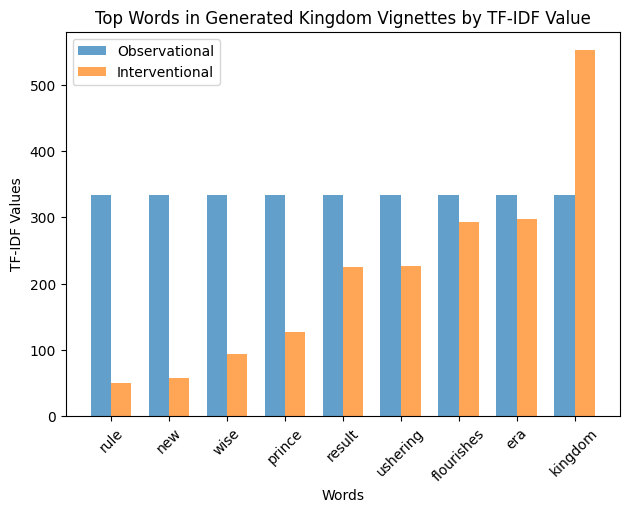

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

#all_samples = pd.read_csv('https://raw.githubusercontent.com/altdeep/causalML/master/book/chapter%2012/kingdom_samples.csv')

observational_texts = all_samples[all_samples["Distribution"] == "observational"]["Kingdom"]    #A
interventional_texts = all_samples[all_samples["Distribution"] == "interventional"]["Kingdom"]    #A

vectorizer = TfidfVectorizer(stop_words='english')    #B
X_obs = vectorizer.fit_transform(observational_texts)    #B
X_int = vectorizer.transform(interventional_texts)    #B

k = 10    #C
feature_names = vectorizer.get_feature_names_out()    #C
obs_indices = X_obs.sum(axis=0).argsort()[0, -k:][::-1]    #C
int_indices = X_int.sum(axis=0).argsort()[0, -k:][::-1]    #C
combined_indices = np.unique(np.concatenate((obs_indices, int_indices)))    #C

labels = [feature_names[i] for i in combined_indices]    #D
labels, indices = np.unique(labels, return_index=True)    #D
obs_values = np.array(X_obs.sum(axis=0))[0, combined_indices]    #D
int_values = np.array(X_int.sum(axis=0))[0, combined_indices]    #D
obs_values = [obs_values[0][i] for i in indices]    #D
int_values = [int_values[0][i] for i in indices]    #D
combined = list(zip(labels, obs_values, int_values))    #D
sorted_combined = sorted(combined, key=lambda x: (-x[1], x[2]))    #D
labels, obs_values, int_values = zip(*sorted_combined)    #D

width = 0.35    #E
x = np.arange(len(labels))    #E
fig, ax = plt.subplots()    #E
rects1 = ax.bar(x - width/2, obs_values, width, label='Observational', alpha=0.7)    #E
rects2 = ax.bar(x + width/2, int_values, width, label='Interventional', alpha=0.7)    #E
ax.set_xlabel('Words')    #E
ax.set_ylabel('TF-IDF Values')    #E
ax.set_title('Top Words in Generated Kingdom Vignettes by TF-IDF Value')    #E
ax.set_xticks(x)    #E
ax.set_xticklabels(labels)    #E
ax.legend()    #E
fig.tight_layout()    #E
plt.xticks(rotation=45)    #E
plt.show()    #E

#A Extract generated Kingdom vignettes from observational and interventional distributions.
#B Compute the tf-idf values for generated Kingdom vignettes in each group.
#C Get the top k=7 words by tf-idf for each set.
#D Prepare data for the bar plot.
#E Produce the plot.